In [1]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
# %pip install earthengine-api --upgrade pandas geopandas > /dev/null
import folium
import json
import requests
import ee
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geopandas as gpd
%matplotlib inline

ee.Authenticate()
ee.Initialize()



# Configurations

In [2]:
city_name = 'Kryvyi_Rih'
start_date = '2022-02-16'
end_date = '2024-02-13'
gdf_boundaries = gpd.read_file(f"{city_name.replace(' ', '_')}_boundary.geojson")

# Getting boundaries

In [3]:

# Get bounding box of gdf_boundaries
bounds = gdf_boundaries.bounds
bounds = bounds.to_dict(orient='list')
bounds = {
    'minlat': bounds['miny'][0],
    'maxlat': bounds['maxy'][0],
    'minlon': bounds['minx'][0],
    'maxlon': bounds['maxx'][0]
}

# Make geojson from bounds
geoJSON = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['minlat']]
                    ]
                ]
            }
        }
    ]
}

center=[(bounds['minlat'] + bounds['maxlat']) / 2, (bounds['minlon'] + bounds['maxlon']) / 2]
bounds

{'minlat': 47.6503431,
 'maxlat': 48.1954303,
 'minlon': 33.139351,
 'maxlon': 33.5987019}

In [4]:
buffer_offset_x = -0.2
buffer_offset_y = -0.3
geoJSON_buffered = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y]
                    ]
                ]
            }
        }
    ]
}

mp = folium.Map(location=center, zoom_start=10)
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
folium.GeoJson(json.dumps(geoJSON_buffered)).add_to(mp)
mp

In [5]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [6]:
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

def det(im):
    """Calculates determinant of 2x2 diagonal covariance matrix."""
    return im.expression('b(0)*b(1)')

In [7]:
aoi = ee.Geometry.Polygon(geoJSON['features'][0]['geometry']['coordinates'])
aoi_sub = ee.Geometry.Polygon(geoJSON_buffered['features'][0]['geometry']['coordinates'])

# Getting EE datasets

In [8]:
test_col = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date)))

# Show relativeOrbitNumber_start for the first image in the collection
relativeOrbitNumber_start = test_col.first().get('relativeOrbitNumber_start').getInfo()
# Show orbitProperties_pass for the first image in the collection
orbitProperties_pass = test_col.first().get('orbitProperties_pass').getInfo()
print(f"Orbit number: {relativeOrbitNumber_start}, pass: {orbitProperties_pass}")

im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
              .sort('system:time_start'))

timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())
timestamplist

Orbit number: 65, pass: DESCENDING


['T20220218',
 'T20220314',
 'T20220326',
 'T20220407',
 'T20220419',
 'T20220501',
 'T20220513',
 'T20220525',
 'T20220606',
 'T20220618',
 'T20220630',
 'T20220712',
 'T20220724',
 'T20220805',
 'T20220817',
 'T20220829',
 'T20220910',
 'T20220922',
 'T20221004',
 'T20221016',
 'T20221028',
 'T20221109',
 'T20221121',
 'T20221203',
 'T20221215',
 'T20221227',
 'T20230108',
 'T20230120',
 'T20230201',
 'T20230213',
 'T20230225',
 'T20230309',
 'T20230321',
 'T20230402',
 'T20230414',
 'T20230426',
 'T20230508',
 'T20230520',
 'T20230601',
 'T20230613',
 'T20230625',
 'T20230707',
 'T20230719',
 'T20230731',
 'T20230812',
 'T20230824',
 'T20230905',
 'T20230917',
 'T20230929',
 'T20231011',
 'T20231023',
 'T20231104',
 'T20231116',
 'T20231128',
 'T20231210',
 'T20231222',
 'T20240103',
 'T20240115',
 'T20240127',
 'T20240208']

In [9]:
# For each date, make mosaic of images from that date
def make_mosaic(date):
    date = ee.Date(date)
    im = ee.Image(im_coll.filterDate(date, date.advance(1, 'day')).mosaic().clip(aoi))
    return im.set('system:time_start', date)

def get_first(date):
    date = ee.Date(date)
    im = ee.Image(im_coll.filterDate(date, date.advance(1, 'day')).first().clip(aoi))
    return im.set('system:time_start', date)

acq_times = im_coll.aggregate_array('system:time_start').getInfo()
im_coll = ee.ImageCollection.fromImages(list(map(make_mosaic, acq_times)))


In [10]:
im_list = im_coll.toList(im_coll.size())
im_list.length().getInfo()

60

In [11]:
im_list.get(10)
# Show bands of 10th image
im = ee.Image(im_list.get(10))
im.bandNames().getInfo()

['VV', 'VH', 'angle']

In [12]:
def selectvv(current):
    return ee.Image(current).select('VV')

vv_list = im_list.map(selectvv)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=10)
rgb_images = (ee.Image.rgb(vv_list.get(10), vv_list.get(11), vv_list.get(12))
              .log10().multiply(10))
mp.add_ee_layer(rgb_images, {'min': -20,'max': 0}, 'rgb composite')
mp.add_child(folium.LayerControl())

In [13]:
alpha = 0.01
print(f"{(1-(1-alpha)**(len(timestamplist)))*100}% of false positives - this we would get if we applied bitemporal method to each of the {len(timestamplist)} intervals")

45.28433576092388% of false positives - this we would get if we applied bitemporal method to each of the 60 intervals


In [14]:
def omnibus(im_list, m = 4.4):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

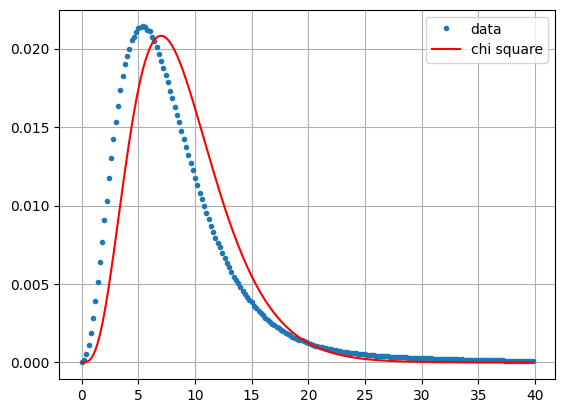

In [15]:
k = 10
hist = (omnibus(vv_list.slice(0,k))
        .reduceRegion(
          ee.Reducer.fixedHistogram(0, 40, 200), 
          geometry=aoi_sub, 
          scale=1, 
          maxPixels=3e9,
          bestEffort=True
        )
        .get('constant')
        .getInfo())

a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Define style function for GeoJSON layer
def style_function(feature):
    return {
        'fillColor': '#ffffff',  # Or whatever fill color you want
        'color': 'none',  # This removes the stroke
        'fillOpacity': 0.5,
        'weight': 0,
    }

# Add satellite image to the map
google_sat = folium.TileLayer(
    tiles='https://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=True,
    control=True,
    subdomains=['mt0', 'mt1', 'mt2', 'mt3']
)
# Pre-made folium map layer with bounds
bounds_layer = folium.GeoJson(json.dumps(geoJSON), name='Bounds', style_function=lambda x: {'fillColor':'none'})

In [17]:
# The change map for alpha = 0.01.
k = 26; alpha = 0.01
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)
# Make the no-change pixels transparent.
c_map = c_map.updateMask(c_map.gt(0))
# Overlay onto the folium map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
# Add change map to the map
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'Change Map')
mp.add_child(folium.LayerControl())

In [18]:
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=11)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
mp.add_ee_layer(c_map, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0, 'max': 1, 'palette': ['black', 'blue']}, 'Change map (10m)')

mp.add_child(folium.LayerControl())

In [19]:
def sample_vv_imgs(j):
    """Samples the test statistics Rj in the region aoi_sub."""
    j = ee.Number(j)
    # Get the factors in the expression for Rj.
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0, j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0, j.subtract(1))).reduce(ee.Reducer.sum())
    # Put them together.
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)
    # Sample Rj.
    sample = (Rj.sample(region=aoi_sub, scale=10, numPixels=1000, seed=123)
              .aggregate_array('VV_sum'))
    return sample

# Sample the first few list indices.
samples = ee.List.sequence(2, 8).map(sample_vv_imgs)

# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)
print(np.corrcoef(samples.getInfo()))

[[1.   0.26 0.1  0.06 0.06 0.03 0.05]
 [0.26 1.   0.1  0.1  0.17 0.06 0.09]
 [0.1  0.1  1.   0.01 0.09 0.02 0.08]
 [0.06 0.1  0.01 1.   0.1  0.06 0.05]
 [0.06 0.17 0.09 0.1  1.   0.06 0.12]
 [0.03 0.06 0.02 0.06 0.06 1.   0.13]
 [0.05 0.09 0.08 0.05 0.12 0.13 1.  ]]


In [20]:
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # Slice the series from k-l+1 to k (image indices start from 0).
        im_list_ell = im_list.slice(k.subtract(ell), k)

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})

        # Map over j=2,3,...,l.
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # Map over l = k to 2.
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

In [21]:
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # Create bmap band and add it to bmap image.
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # Filter Ql p value if desired.
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

In [22]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0, k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    return ee.Dictionary(pv_arr.iterate(filter_i, first))

In [23]:
result = change_maps(im_list, median=True, alpha=0.05)

# Extract the change maps and display.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'blue', 'cyan', 'yellow', 'red']
mp = folium.Map(location=location, zoom_start=11)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
mp.add_ee_layer(cmap, {'min': 0, 'max': 25, 'palette': palette}, 'cmap')
mp.add_ee_layer(smap, {'min': 0, 'max': 25, 'palette': palette}, 'smap')
mp.add_ee_layer(fmap, {'min': 0, 'max': 25, 'palette': palette}, 'fmap')
mp.add_child(folium.LayerControl())

In [24]:
def dmap_iter(current, prev):
    """Reclassifies values in directional change maps."""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # Reset avimg to current image and set i=1 if change occurred.
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

In [25]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

In [26]:
# Run the algorithm with median filter and at 1% significance.
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))
# Extract the change maps and export to assets.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
bmap = ee.Image(result.get('bmap'))
cmaps = ee.Image.cat(cmap, smap, fmap, bmap).rename(['cmap', 'smap', 'fmap']+timestamplist[1:])

# EDIT THE ASSET PATH TO POINT TO YOUR ACCOUNT.
assetId = 'users/hermanmitish/cmaps'

assexport = ee.batch.Export.image.toAsset(cmaps,
                                          description='assetExportTask',
                                          assetId=assetId, scale=10, maxPixels=1e9)

# UNCOMMENT THIS TO EXPORT THE MAP TO YOUR ACCOUNT.
# assexport.start()

In [27]:
# cmaps = ee.Image(assetId)
cmaps = cmaps.updateMask(cmaps.gt(0))

location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'red', 'cyan', 'yellow']
# mp = folium.Map(location=location, zoom_start=11)
# bounds_layer.add_to(mp)
# google_sat.add_to(mp)
# for timestamp in timestamplist[1:]:
#     mp.add_ee_layer(cmaps.select(timestamp), {'min': 0,'max': 3, 'palette': palette}, timestamp)

# mp.add_child(folium.LayerControl())

In [28]:
# Assuming `cmaps` is your image collection or image
for timestamp in timestamplist[1:]:
    image = cmaps.select(timestamp)
    
    # Define export parameters
    task = ee.batch.Export.image.toDrive(**{
        'image': image,
        'description': f'{city_name}_change_map_full_{timestamp}',
        'folder': 'GEE_exports',  # Specify your Google Drive folder name
        'fileNamePrefix': f'{city_name}_change_map_full_{timestamp}',
        'scale': 10,
        'crs': 'EPSG:4326',
        'fileFormat': 'GeoTIFF',
        'maxPixels': 3e9  # Adjust as needed to avoid exceeding pixel limits,
    })
    
    # Start the export task
    task.start()

    print(f'Exporting {city_name}_change_map_full_{timestamp}.tif to Drive started.')

Exporting Kryvyi_Rih_change_map_full_T20220314.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220326.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220407.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220419.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220501.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220513.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220525.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220606.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220618.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220630.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220712.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220724.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220805.tif to Drive started.
Exporting Kryvyi_Rih_change_map_full_T20220817.tif to Drive started.
Exporting Kryvyi_Rih_change_map_fu